In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_R2 import _dataset, VAE, study#, compare_distributions_binned_aux, compare_distributions_binned
from VAE_OPTIMIZATION_WD import compare_continuous, compare_integer

[I 2021-08-02 10:45:33,531] Using an existing study with name 'Optimizing the VAE with R2 - BKG vs Reconstruction' instead of creating a new one.
[I 2021-08-02 10:45:33,597] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


In [2]:
import time
time.sleep(1)

## Loading the Study

In [3]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 106
Best trial:
  Value: 0.9859930944929812
  Params: 
    alpha: 3051
    hidden_size: 35
    lr: 0.000558675348595003
    n_layers_decoder: 1
    n_layers_encoder: 1
    n_units_decoder_l0: 425
    n_units_encoder_l0: 370
 TRIAL NUMBER: 67


### Optuna Graphs

In [4]:
optuna.visualization.plot_param_importances(study)

In [5]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [6]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "r2-reconstruction_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_R2-Data_vs_Reconstruction_trial_67"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=370, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=370, out_features=35, bias=True)
  )
  (hidden2mu): Linear(in_features=35, out_features=35, bias=True)
  (hidden2log_var): Linear(in_features=35, out_features=35, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=35, out_features=425, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=425, out_features=69, bias=True)
  )
)

### Load data

In [7]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [8]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 35)

<ipython-input-9-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



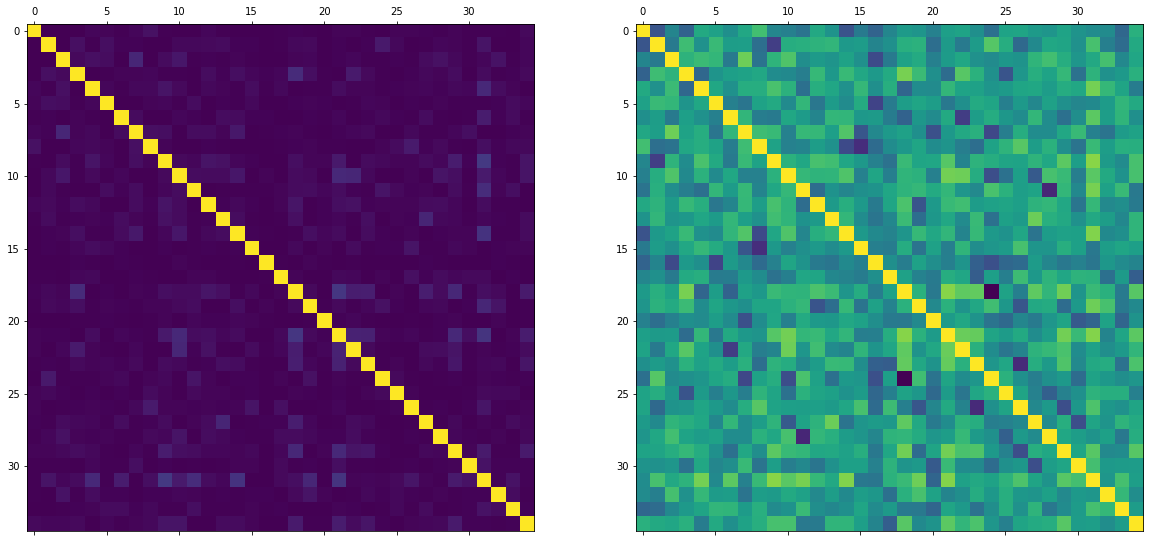

In [9]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [10]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.16661
Mean:	 0.01768


Mean: 0.06030958 	Std: 0.9856668
Mean: -0.02285887 	Std: 0.9778001
Mean: -0.011519676 	Std: 1.0107541
Mean: -0.015595461 	Std: 1.0010226
Mean: -0.021547357 	Std: 0.99768084
Mean: 0.050863344 	Std: 0.986747
Mean: -0.0091041075 	Std: 0.9868491
Mean: 0.041009102 	Std: 1.0045406
Mean: -0.0376594 	Std: 0.9828316
Mean: 0.05164098 	Std: 1.0220486
Mean: -0.016534353 	Std: 1.0061458
Mean: 0.008585934 	Std: 0.990406
Mean: 0.0094776 	Std: 1.013246
Mean: -0.011124336 	Std: 0.98283523
Mean: -0.030810889 	Std: 0.99089867
Mean: 0.019694641 	Std: 0.98128414
Mean: 0.018796727 	Std: 0.98773396
Mean: -0.010886483 	Std: 0.9873501
Mean: -0.022215655 	Std: 1.0043443
Mean: 0.07001832 	Std: 0.9923795
Mean: 0.014205908 	Std: 0.98673517
Mean: 0.022439143 	Std: 0.9940381
Mean: -0.021332813 	Std: 0.9894778
Mean: 0.01137971 	Std: 0.97366333
Mean: -0.033069436 	Std: 0.98975724
Mean: 0.031317696 	Std: 0.9883203
Mean: -0.023545476 	Std: 0.9747143
Mean: 0.034428697 	Std: 0.9884105
Mean: 0.058207393 	Std: 0.9932584
Mea

<ipython-input-11-3e65db6d3c91>:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



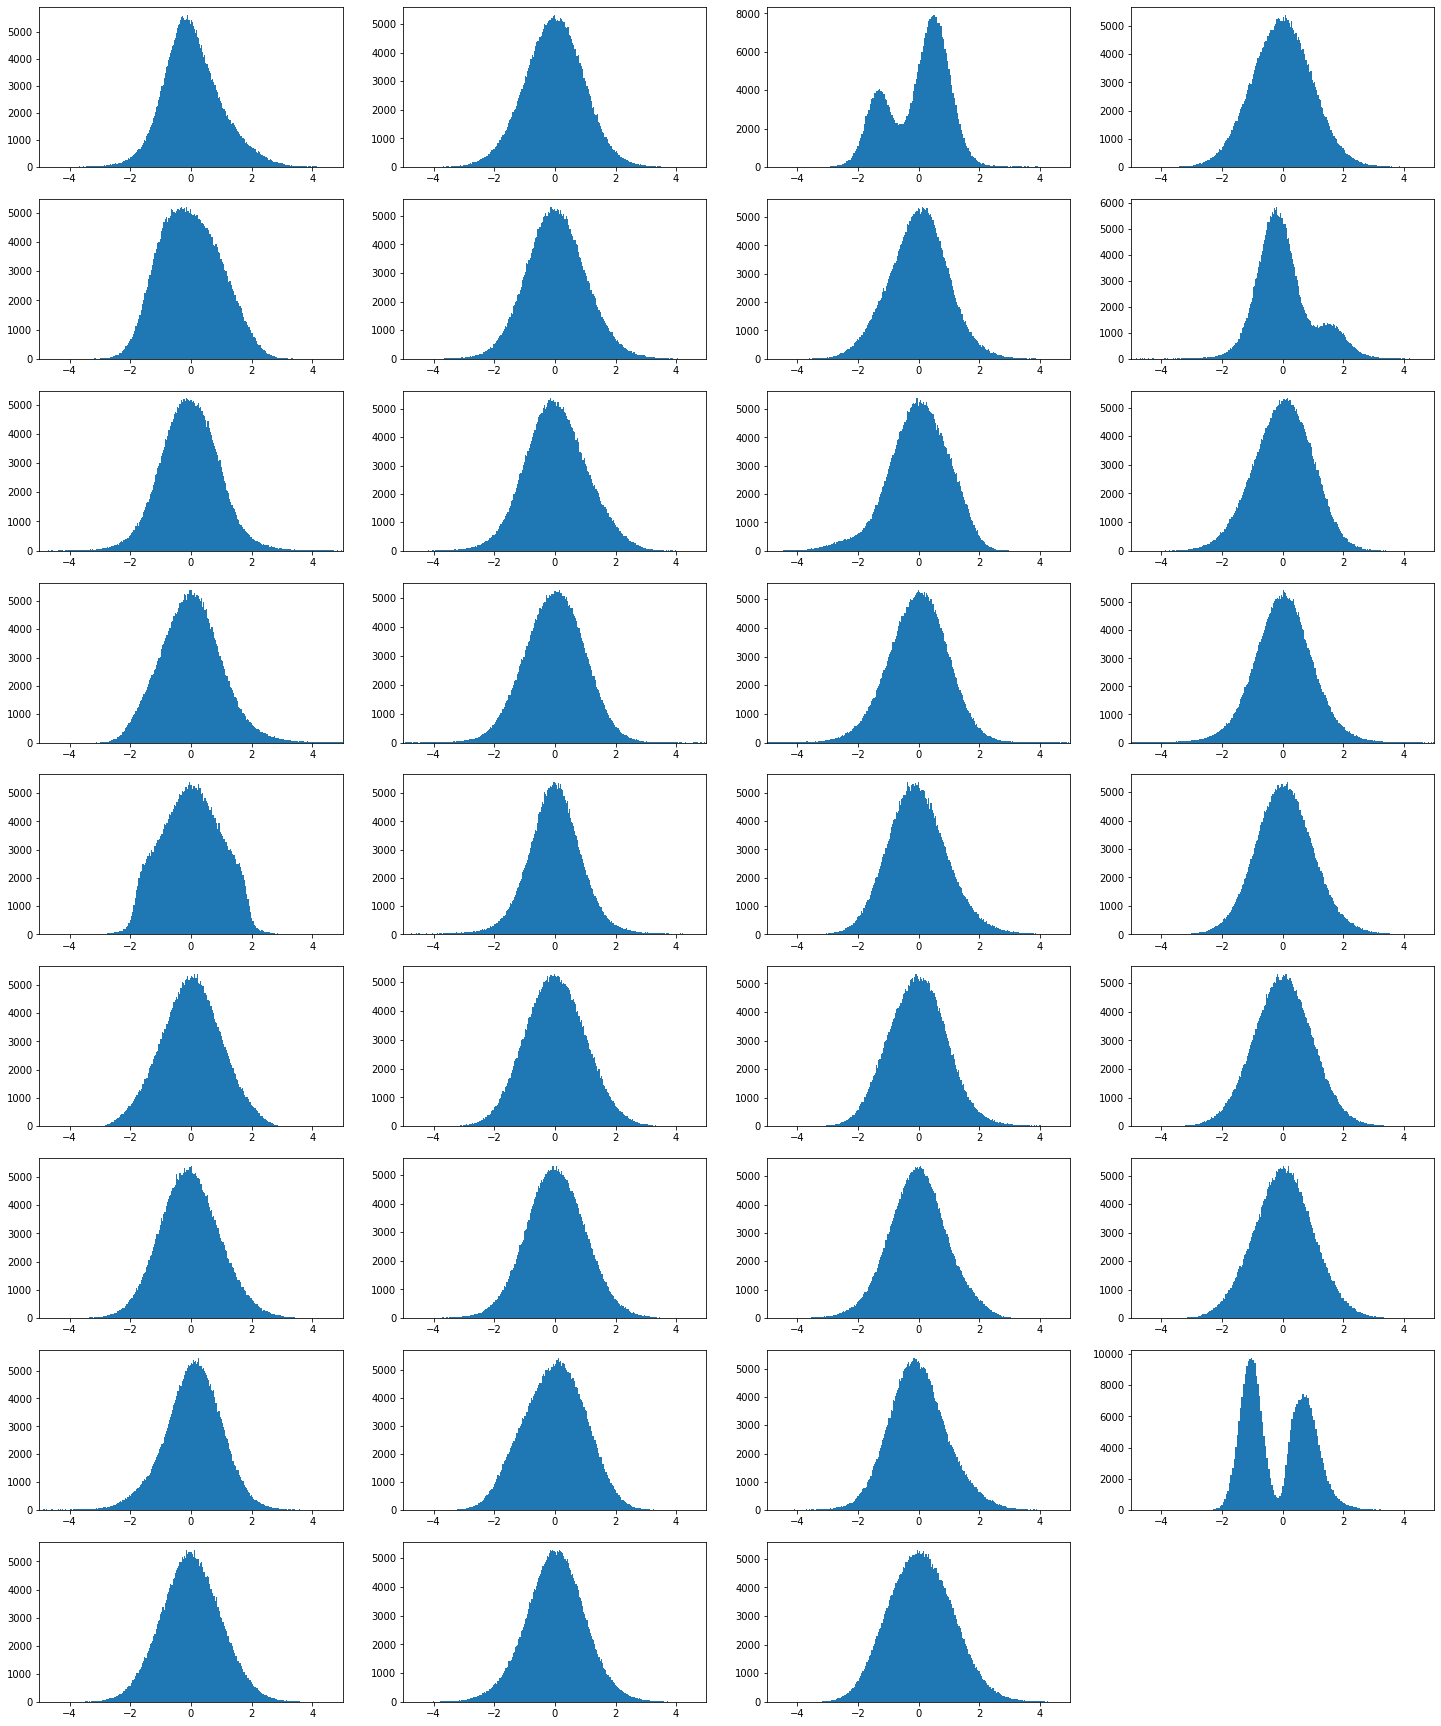

In [11]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.show()

## Bkg Data vs Random Sampling Decoding

In [12]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_MET,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT
count,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,...,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000
mean,0.197908,-0.488674,0.427380,0.003361,-0.506362,0.021029,-0.418869,0.200434,0.317202,0.305985,...,0.402249,-0.755748,-0.155857,0.934426,0.090526,0.561392,-0.492788,-0.562533,0.388458,-0.053212
std,0.372347,0.398690,0.523165,0.016806,0.011732,0.027406,0.446632,0.292324,0.315910,0.234673,...,0.330982,0.324471,0.367435,0.429209,0.434152,0.549024,0.258201,0.526889,0.447149,0.253753
min,-1.550744,-0.880573,-0.561000,-0.248004,-0.544138,-1.702524,-0.931321,-1.112797,-0.855060,-0.488972,...,-0.710932,-2.016248,-1.581943,-0.948860,-1.598632,-0.546967,-0.805805,-2.550820,-1.216565,-0.954382
25%,-0.001722,-0.716165,-0.008741,-0.004057,-0.513529,0.012678,-0.882748,0.000970,0.111190,0.140549,...,0.169567,-0.978786,-0.412304,0.693466,-0.196816,-0.023096,-0.669404,-0.978959,-0.147797,-0.228894
50%,0.008755,-0.686811,0.158835,-0.000208,-0.507095,0.020508,-0.553770,0.200143,0.340210,0.302191,...,0.397682,-0.755860,-0.162351,0.970893,0.112314,0.537567,-0.639110,-0.449075,0.526899,-0.056875
75%,0.348856,-0.389030,0.837858,0.005948,-0.499027,0.030360,0.115813,0.399217,0.536954,0.467832,...,0.626461,-0.532423,0.094136,1.221106,0.394719,1.000607,-0.362657,-0.062818,0.849638,0.119812
max,2.088063,2.153641,2.533811,1.026794,-0.273060,0.094754,1.186240,1.383660,1.601033,1.246657,...,1.975862,0.520562,1.365600,2.532584,1.616244,2.595527,1.060938,0.593144,0.899239,1.033016


In [13]:
bkg.shape, sample.shape

((341121, 69), (341121, 69))

In [14]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += compare_distributions_binned_aux(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("WD_Score:", compare_distributions_binned(background, bkg_weights, sample, np.ones(bkg_weights.shape), bins=100))
    #print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

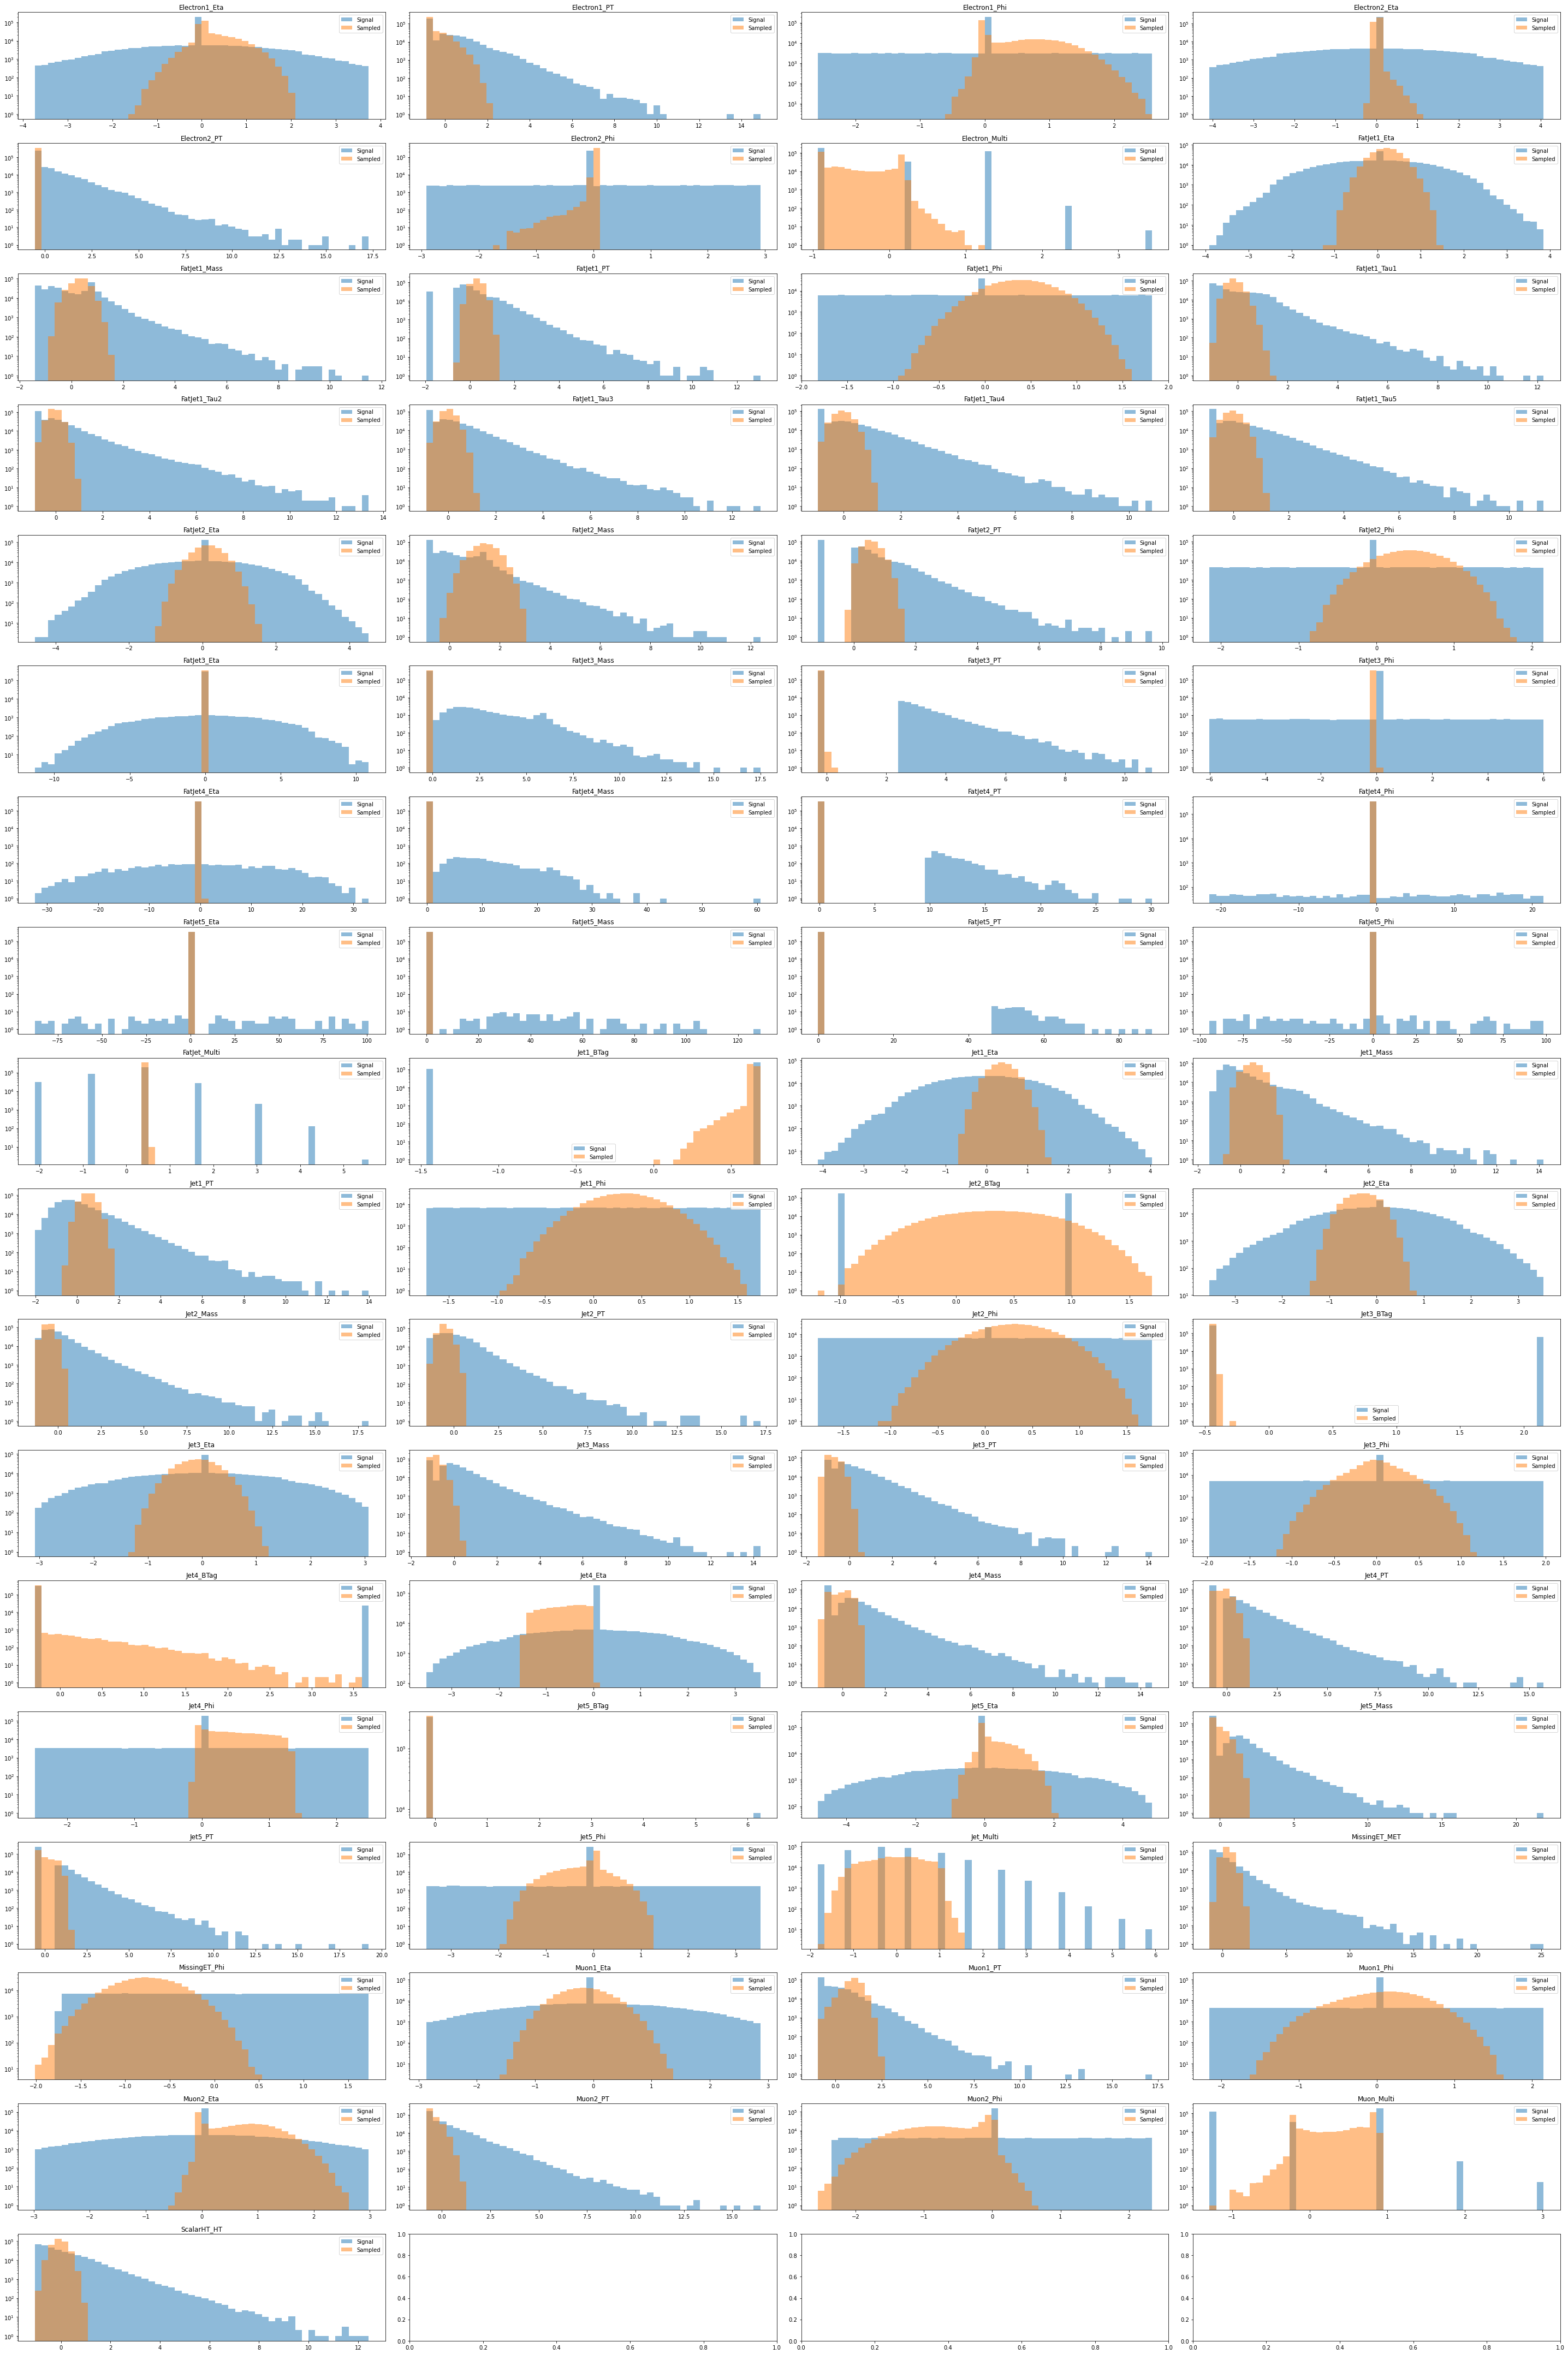

In [15]:
plot_graphs2(bkg, sample)

In [16]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 15.835778474336337


## Bkg Data vs Reconstruction

In [17]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

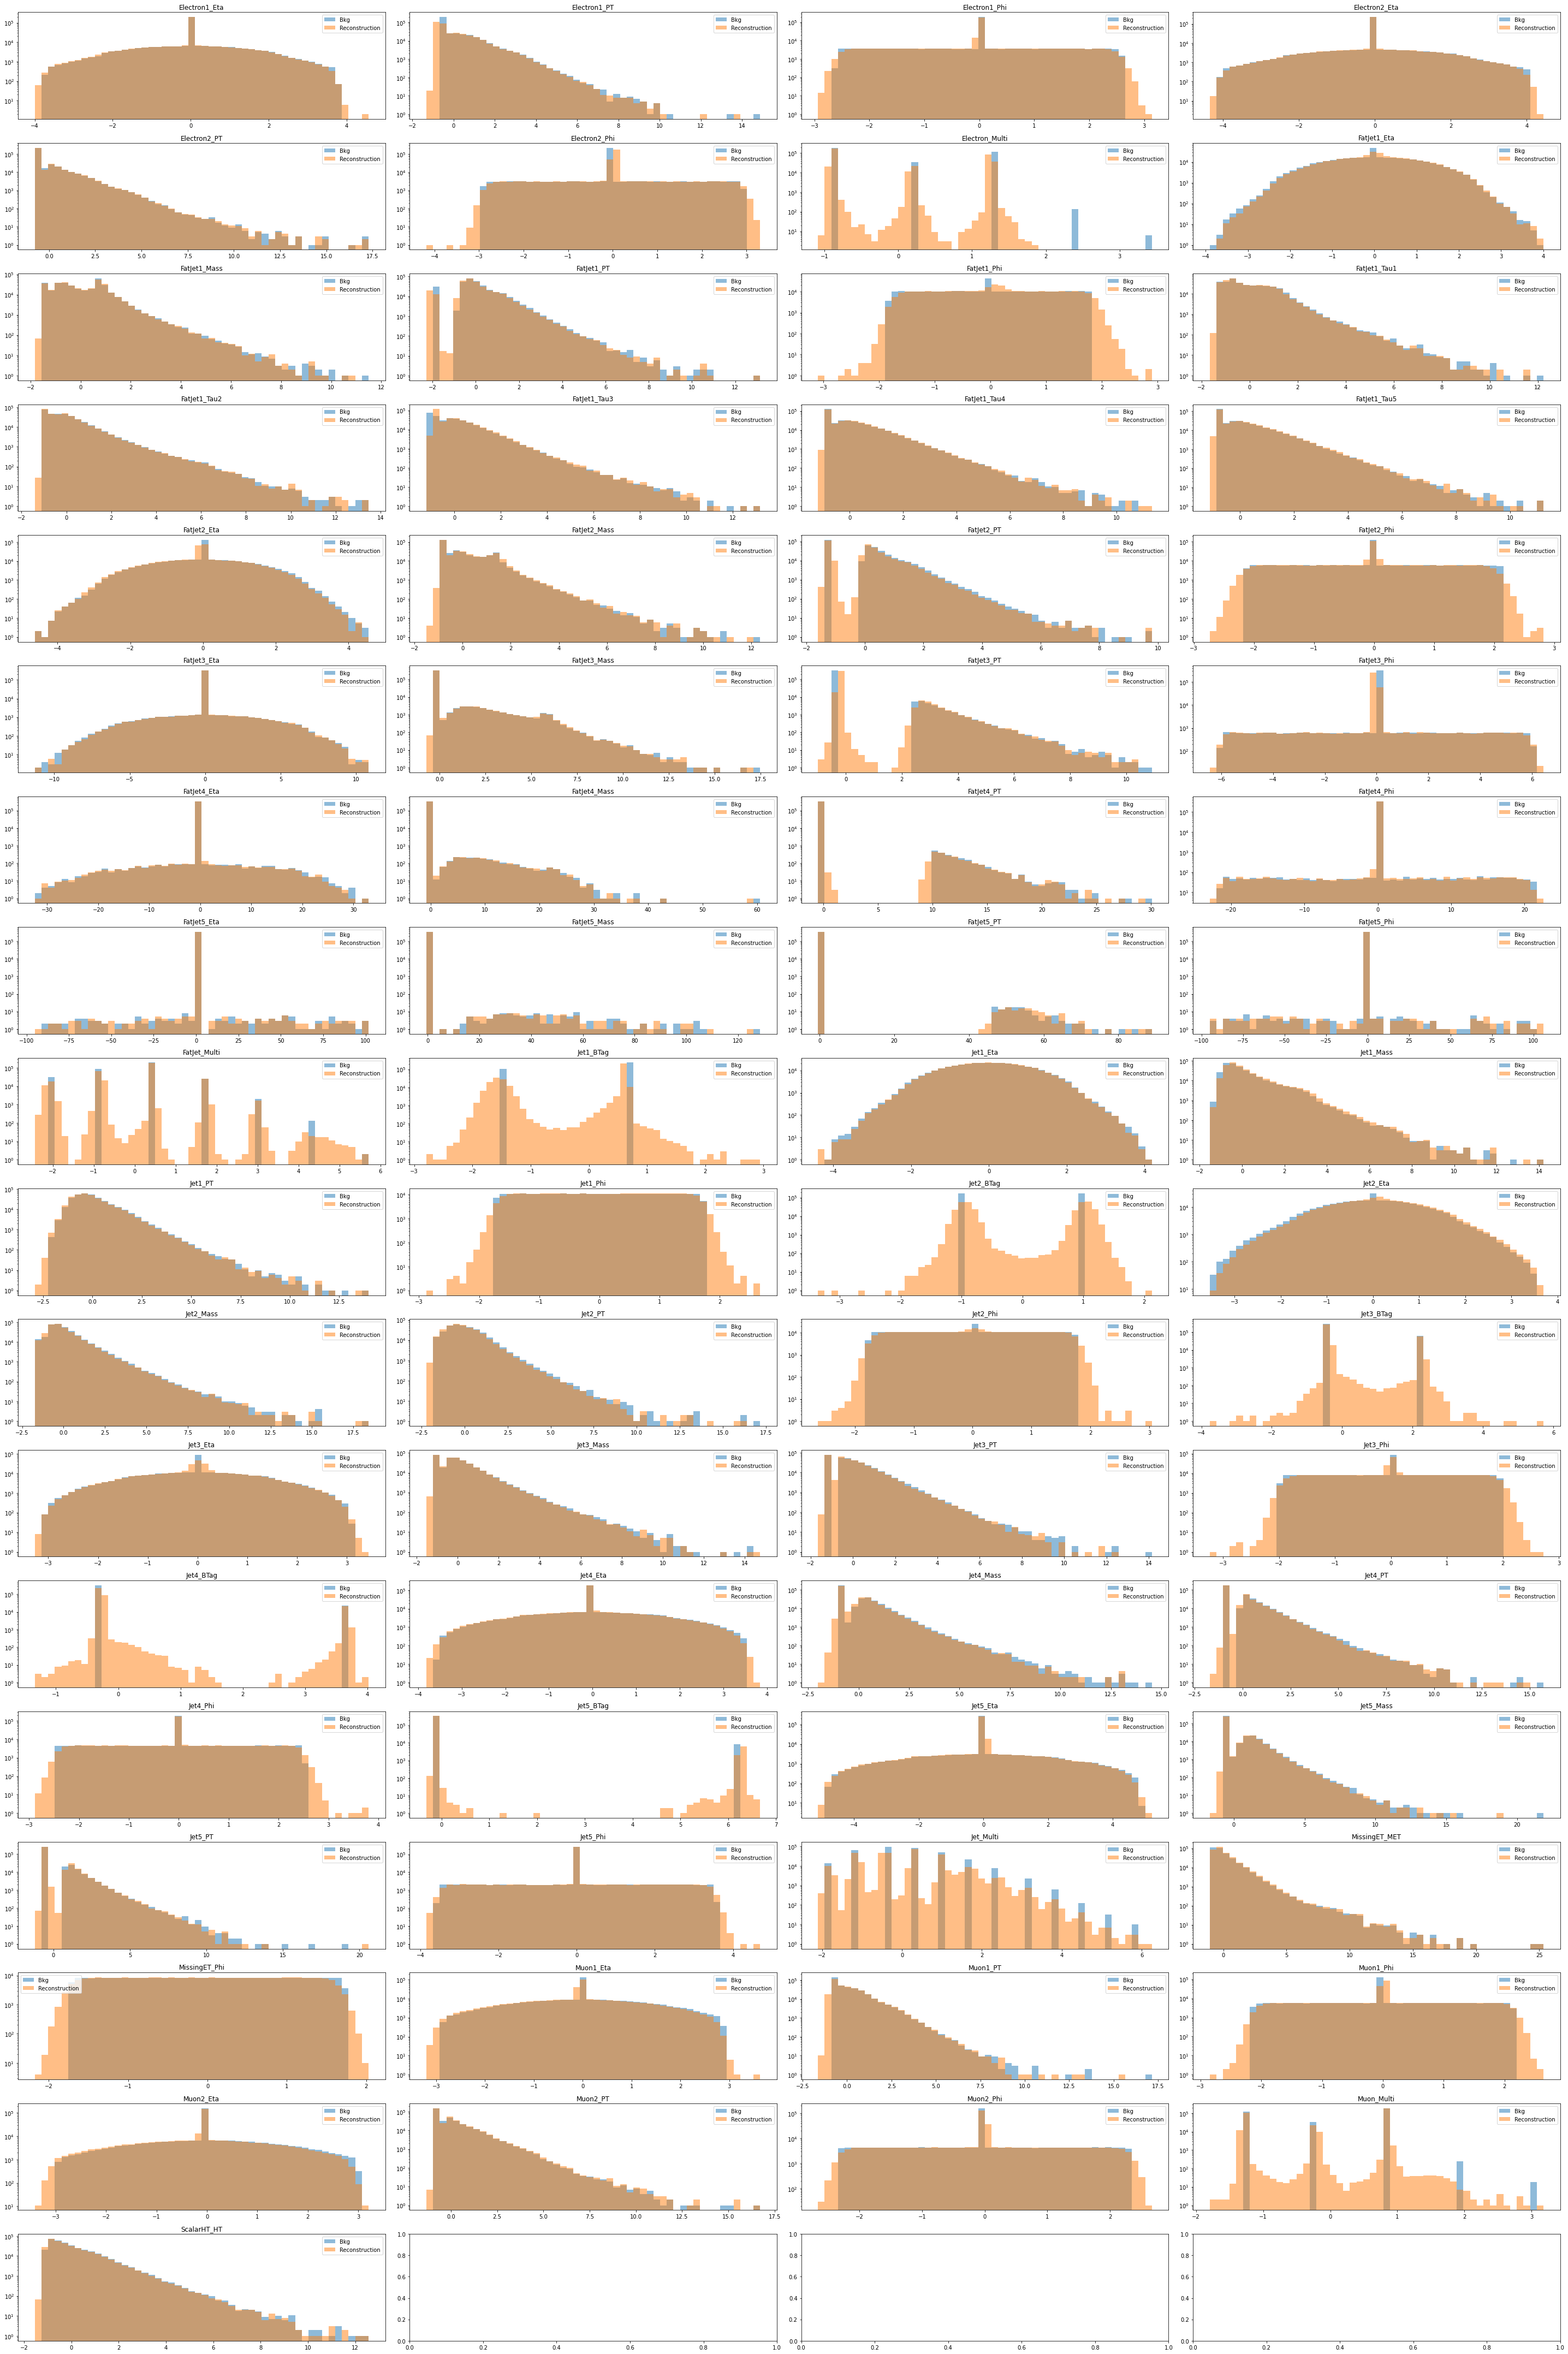

In [18]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [19]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.9886919811680888


## Plot error distributions and ROC Score

Load data

In [20]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for hg3000_hq1000: 0.9996654293609
Confusion matrix:
[[341103     18]
 [ 26369   2371]]


ROC SCORE for wohg_hq1000: 0.9996727372008858
Confusion matrix:
[[341103     18]
 [ 26990   2640]]


ROC SCORE for hg3000_hq1200: 0.9996838329767525
Confusion matrix:
[[341103     18]
 [ 24440   2064]]


ROC SCORE for wohg_hq1200: 0.9996913480239252
Confusion matrix:
[[341103     18]
 [ 25157   2152]]


ROC SCORE for fcnc: 0.9525216312978775
Confusion matrix:
[[341103     18]
 [101422      9]]


ROC SCORE for hg3000_hq1400: 0.9996848817888565
Confusion matrix:
[[341103     18]
 [ 24778   1896]]


ROC SCORE for wohg_hq1400: 0.9996973987125902
Confusion matrix:
[[341103     18]
 [ 23723   1774]]




<ipython-input-21-780b8fc689f9>:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



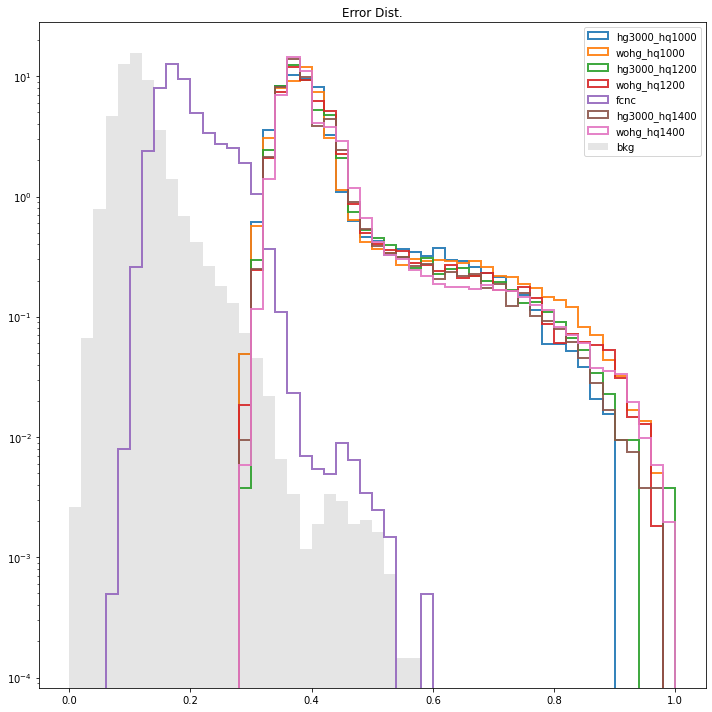

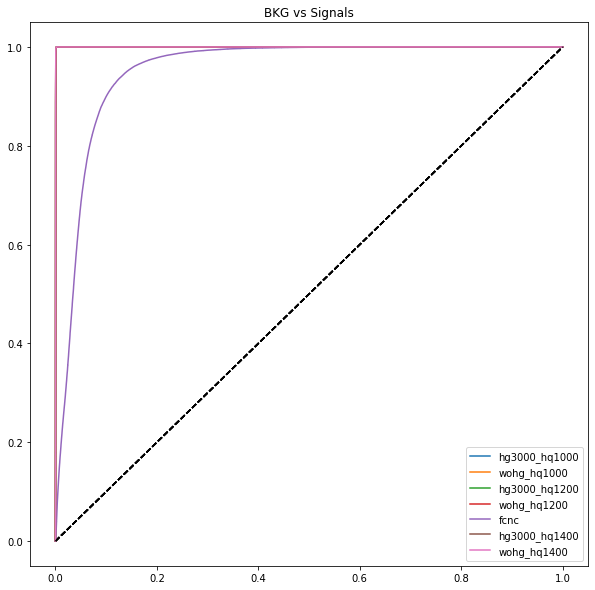

In [22]:
plot_graphs3(data)